In [3]:
import warnings

warnings.filterwarnings( "ignore", module = "matplotlib\..*" )

import numpy as np
import pandas as pd
import scanpy as sc
import os
sc.settings.verbosity = 0

import matplotlib
from matplotlib import pyplot as plt
import seaborn as sns

# Peaks data
from scipy.io import mmread

%matplotlib inline

sns.set_style('ticks')
matplotlib.rcParams['figure.figsize'] = [4, 4]
matplotlib.rcParams['figure.dpi'] = 100

sc.set_figure_params(figsize=(4,4),dpi=120)

### Load data

In [5]:
os.chdir('/lustre/scratch/kiviaho/spatac/notebooks')
rna = sc.read_h5ad('../data/rna_tonsil_multiome.h5ad')
rna.var_names_make_unique
atac = sc.read_h5ad('../data/atac_tonsil_multiome.h5ad')
atac.var_names_make_unique

rna.layers["counts"] = rna.raw.X.copy()
atac.layers["counts"] = atac.raw.X.copy()

In [6]:
atac

AnnData object with n_obs × n_vars = 4453 × 146117
    obs: 'Sample', 'TSSEnrichment', 'ReadsInTSS', 'ReadsInPromoter', 'ReadsInBlacklist', 'PromoterRatio', 'PassQC', 'NucleosomeRatio', 'nMultiFrags', 'nMonoFrags', 'nFrags', 'nDiFrags', 'BlacklistRatio', 'Clusters', 'ReadsInPeaks', 'FRIP', 'celltype', 'leiden', 'rna_leiden', 'broad_celltype'
    var: 'seqnames', 'start', 'end', 'width', 'strand', 'score', 'replicateScoreQuantile', 'groupScoreQuantile', 'Reproducibility', 'GroupReplicate', 'nearestGene', 'distToGeneStart', 'peakType', 'distToTSS', 'nearestTSS', 'GC', 'idx', 'N'
    uns: 'GeneScoresColums', 'broad_celltype_colors', 'leiden', 'leiden_colors', 'neighbors', 'rna_leiden_colors', 'umap'
    obsm: 'GeneScores', 'X_svd', 'X_umap'
    layers: 'counts'
    obsp: 'connectivities', 'distances'

In [7]:
atac

AnnData object with n_obs × n_vars = 4453 × 146117
    obs: 'Sample', 'TSSEnrichment', 'ReadsInTSS', 'ReadsInPromoter', 'ReadsInBlacklist', 'PromoterRatio', 'PassQC', 'NucleosomeRatio', 'nMultiFrags', 'nMonoFrags', 'nFrags', 'nDiFrags', 'BlacklistRatio', 'Clusters', 'ReadsInPeaks', 'FRIP', 'celltype', 'leiden', 'rna_leiden', 'broad_celltype'
    var: 'seqnames', 'start', 'end', 'width', 'strand', 'score', 'replicateScoreQuantile', 'groupScoreQuantile', 'Reproducibility', 'GroupReplicate', 'nearestGene', 'distToGeneStart', 'peakType', 'distToTSS', 'nearestTSS', 'GC', 'idx', 'N'
    uns: 'GeneScoresColums', 'broad_celltype_colors', 'leiden', 'leiden_colors', 'neighbors', 'rna_leiden_colors', 'umap'
    obsm: 'GeneScores', 'X_svd', 'X_umap'
    layers: 'counts'
    obsp: 'connectivities', 'distances'

In [5]:
# # Save single-cell-resolution-data-for-glue
atac.write('../integrations/tonsilatlas/single_cell_all/atac.h5ad')
atac.write('../integrations/tonsilatlas/single_cell_all/rna.h5ad')

## Synthetic spatial spot sampling

In [6]:
seed = 59541

n_locations = [100, 100] # 50*50 grid
n_experiments = 1 # Changed from 10

# sparsity and tissue zones
n_tissue_zones = 8 # Changed from 12
n_uniform = 0 # Changed from 8

# low and high density cell types
p_high_density = 0.8 # Changed from 0.2, 
mu_low_density = 1.0
mu_high_density = 2.8

In [7]:
seed = 121443

n_locations = [100, 100] # 50*50 grid
n_experiments = 1 # Changed from 10

# sparsity and tissue zones
n_tissue_zones = 6 # Changed from 12
n_uniform = 0 # Changed from 8

# low and high density cell types
p_high_density = 0.8 # Changed from 0.2, 
mu_low_density = 1.0
mu_high_density = 2.8

## simulation settings
np.random.seed(seed)

## generate per cell type simulation attributes
n_cell_types = rna.obs['broad_celltype'].value_counts().shape[0]
n_sparse = n_cell_types - n_uniform
n_zones_per_cell_type = np.random.binomial(n_tissue_zones, 0.05, size=n_sparse)+1

experiment_id = np.repeat(np.arange(n_experiments), np.prod(n_locations))
cell_types = np.array(rna.obs['broad_celltype'].unique())
uniform_cell_types = np.random.choice(cell_types, n_uniform, replace=False)
sparse_cell_types = cell_types[~np.isin(cell_types, uniform_cell_types)]

# generate matrix of which cell types are in which zones
cell_types2zones = pd.DataFrame(0, index=cell_types, 
                                columns=[f'tissue_zone_{i}' for i in range(n_tissue_zones)] \
                                + [f'uniform_{i}' for i in range(n_uniform)])
for i, n in enumerate(n_zones_per_cell_type):
    pos = np.random.randint(n_tissue_zones, size=n)
    cell_types2zones.iloc[i,pos] = 1
    
# and which uniform cell types belong to which uniform pattern
for i in range(n_uniform):
    cell_types2zones.iloc[n_sparse+i, n_tissue_zones+i] = 1
    
cell_types2zones.sum(), cell_types2zones.sum(1)

(tissue_zone_0    2
 tissue_zone_1    1
 tissue_zone_2    2
 tissue_zone_3    3
 tissue_zone_4    1
 tissue_zone_5    2
 dtype: int64,
 GCBC       2
 NBC-MBC    2
 preB       1
 CD8-T      1
 Th         1
 PDC        1
 PC         2
 myeloid    1
 dtype: int64)

In [8]:
np.random.seed(seed)
# Assign cell types to either high or low density, balanced by uniform / tissue zone
high_density_cell_types = list(np.random.choice(uniform_cell_types, 
                                                int(np.round(n_uniform * p_high_density)), 
                                                replace=False))
for z, n in cell_types2zones.sum().items():
    
    ct = list(np.random.choice(cell_types2zones.index[cell_types2zones[z] > 0], 
                                                int(np.round(n * p_high_density)), 
                                                replace=False))
    print(ct)
    high_density_cell_types = high_density_cell_types + ct
    
low_density_cell_types = cell_types[~np.isin(cell_types, high_density_cell_types)]
    
# what proportion of cells are uniform?
len(high_density_cell_types) / len(cell_types)

['GCBC', 'PC']
['CD8-T']
['GCBC', 'PDC']
['PC', 'NBC-MBC']
['preB']
['NBC-MBC', 'myeloid']


1.25

In [9]:
cell_types2zones

,tissue_zone_0,tissue_zone_1,tissue_zone_2,tissue_zone_3,tissue_zone_4,tissue_zone_5
GCBC,1,0,1,0,0,0
NBC-MBC,0,0,0,1,0,1
preB,0,0,0,0,1,0
CD8-T,0,1,0,0,0,0
Th,0,0,0,1,0,0
PDC,0,0,1,0,0,0
PC,1,0,0,1,0,0
myeloid,0,0,0,0,0,1


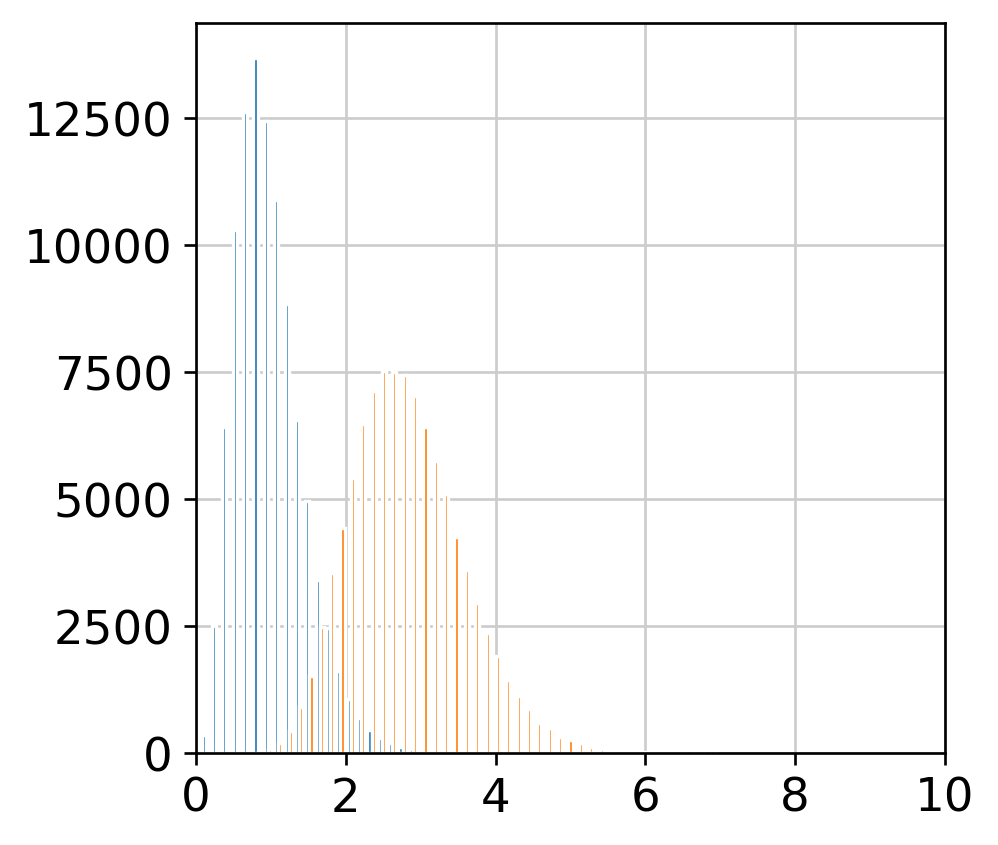

In [10]:
np.random.seed(seed)
#Generate average abundance for low and high density cell types
mean_var_ratio = 5
plt.hist([np.random.gamma(mu_low_density * mean_var_ratio, 1/mean_var_ratio, size=int(1e5)),
          np.random.gamma(mu_high_density * mean_var_ratio, 1/mean_var_ratio, size=int(1e5))], bins=50);
plt.xlim(0, 10);

cell_types2zones.loc[low_density_cell_types] = cell_types2zones.loc[low_density_cell_types] \
 * np.random.gamma(mu_low_density * mean_var_ratio, 
                   1/mean_var_ratio, 
                   size=(len(low_density_cell_types), 1))

cell_types2zones.loc[high_density_cell_types] = cell_types2zones.loc[high_density_cell_types] \
 * np.random.gamma(mu_high_density * mean_var_ratio, 
                   1/mean_var_ratio, 
                   size=(len(high_density_cell_types), 1))

In [11]:
cell_types2zones

,tissue_zone_0,tissue_zone_1,tissue_zone_2,tissue_zone_3,tissue_zone_4,tissue_zone_5
GCBC,4.240786,0.000000,4.240786,0.000000,0.000000,0.000000
NBC-MBC,0.000000,0.000000,0.000000,2.212703,0.000000,2.212703
preB,0.000000,0.000000,0.000000,0.000000,1.373336,0.000000
CD8-T,0.000000,4.732092,0.000000,0.000000,0.000000,0.000000
Th,0.000000,0.000000,0.000000,1.097164,0.000000,0.000000
PDC,0.000000,0.000000,3.100571,0.000000,0.000000,0.000000
PC,2.381093,0.000000,0.000000,2.381093,0.000000,0.000000
myeloid,0.000000,0.000000,0.000000,0.000000,0.000000,2.271700


In [15]:
def cartesian(*arrays):
    """Makes the Cartesian product of arrays.

    Parameters
    ----------
    arrays: N-D array-like
            N-D arrays where earlier arrays loop more slowly than later ones
    """
    N = len(arrays)
    arrays_np = [np.asarray(x) for x in arrays]
    arrays_2d = [x[:, None] if np.asarray(x).ndim == 1 else x for x in arrays_np]
    arrays_integer = [np.arange(len(x)) for x in arrays_2d]
    product_integers = np.stack(np.meshgrid(*arrays_integer, indexing="ij"), -1).reshape(-1, N)
    return np.concatenate(
        [array[product_integers[:, i]] for i, array in enumerate(arrays_2d)], axis=-1
    )

def kernel(X1, X2, l=1.0, eta=1.0):
    '''
    Isotropic squared exponential kernel. Computes 
    a covariance matrix from points in X1 and X2.
    
    Args:
        X1: Array of m points (m x d).
        X2: Array of n points (n x d).

    Returns:
        Covariance matrix (m x n).
    '''
    sqdist = np.sum(X1**2, 1).reshape(-1, 1) + np.sum(X2**2, 1) - 2 * np.dot(X1, X2.T)
    return eta**2 * np.exp(-0.5 / l**2 * sqdist)
    
def generate_grid(
              n=[50, 50] #spatial dimensions 
):
    n1, n2 = n 
    x1 = np.linspace(0, 100, n1)[:,None] #saptial dimensions 
    x2 = np.linspace(0, 100, n2)[:,None] #saptial dimensions 

    # make cartesian grid out of each dimension x1 and x2
    return cartesian(x1[:,None], x2[:,None]), x1, x2

def random_GP(X, x1=1, x2=1, #coordinates
              n_variables = 5, #zones
              eta_true = 5, #variance, defines overlapping
              l1_true=[8, 10, 15], #bw parameter
              l2_true=[8, 10, 15]
             ):

    #cov1, cov2 = kernel(x1, x1, l=l1_true), kernel(x2, x2, l=l2_true)
    K = [np.kron(kernel(x1, x1, l=l1_true[i], eta=eta_true), 
                 kernel(x2, x2, l=l2_true[i], eta=eta_true)) 
         for i in range(n_variables)]

    gaus_true = np.stack([np.random.multivariate_normal(np.zeros(X.shape[0]), 
                                                        2*K[i]) 
                          for i in range(n_variables)]).T #samples from GP
    N_true = (np.exp(gaus_true).T / np.exp(gaus_true).sum(axis=1)).T #softmax transform, eq 48
    return N_true


def plot_spatial(values, n=[50,50], nrows=5, names=['cell type'],
                 vmin=0, vmax=1):
    
    n_cell_types = values.shape[1]
    n1, n2 = n 
    ncols = int(np.ceil((n_cell_types+1) / nrows))
    for ct in range(n_cell_types):
        plt.subplot(nrows, ncols, ct+1)
        plt.imshow(values[:,ct].reshape(n1,n2).T, 
                   cmap=plt.cm.get_cmap('magma'),
                   vmin=vmin, vmax=vmax
                  )
        plt.colorbar()
        if len(names) > 1:
            plt.title(names[ct])
        else:
            plt.title(f'{names[0]} {ct+1}')

    plt.subplot(nrows, ncols, n_cell_types+1) 
    plt.imshow(values.sum(axis=1).reshape(n1,n2).T, 
               cmap=plt.cm.get_cmap('Greys'))
    plt.colorbar()
    plt.title('total')

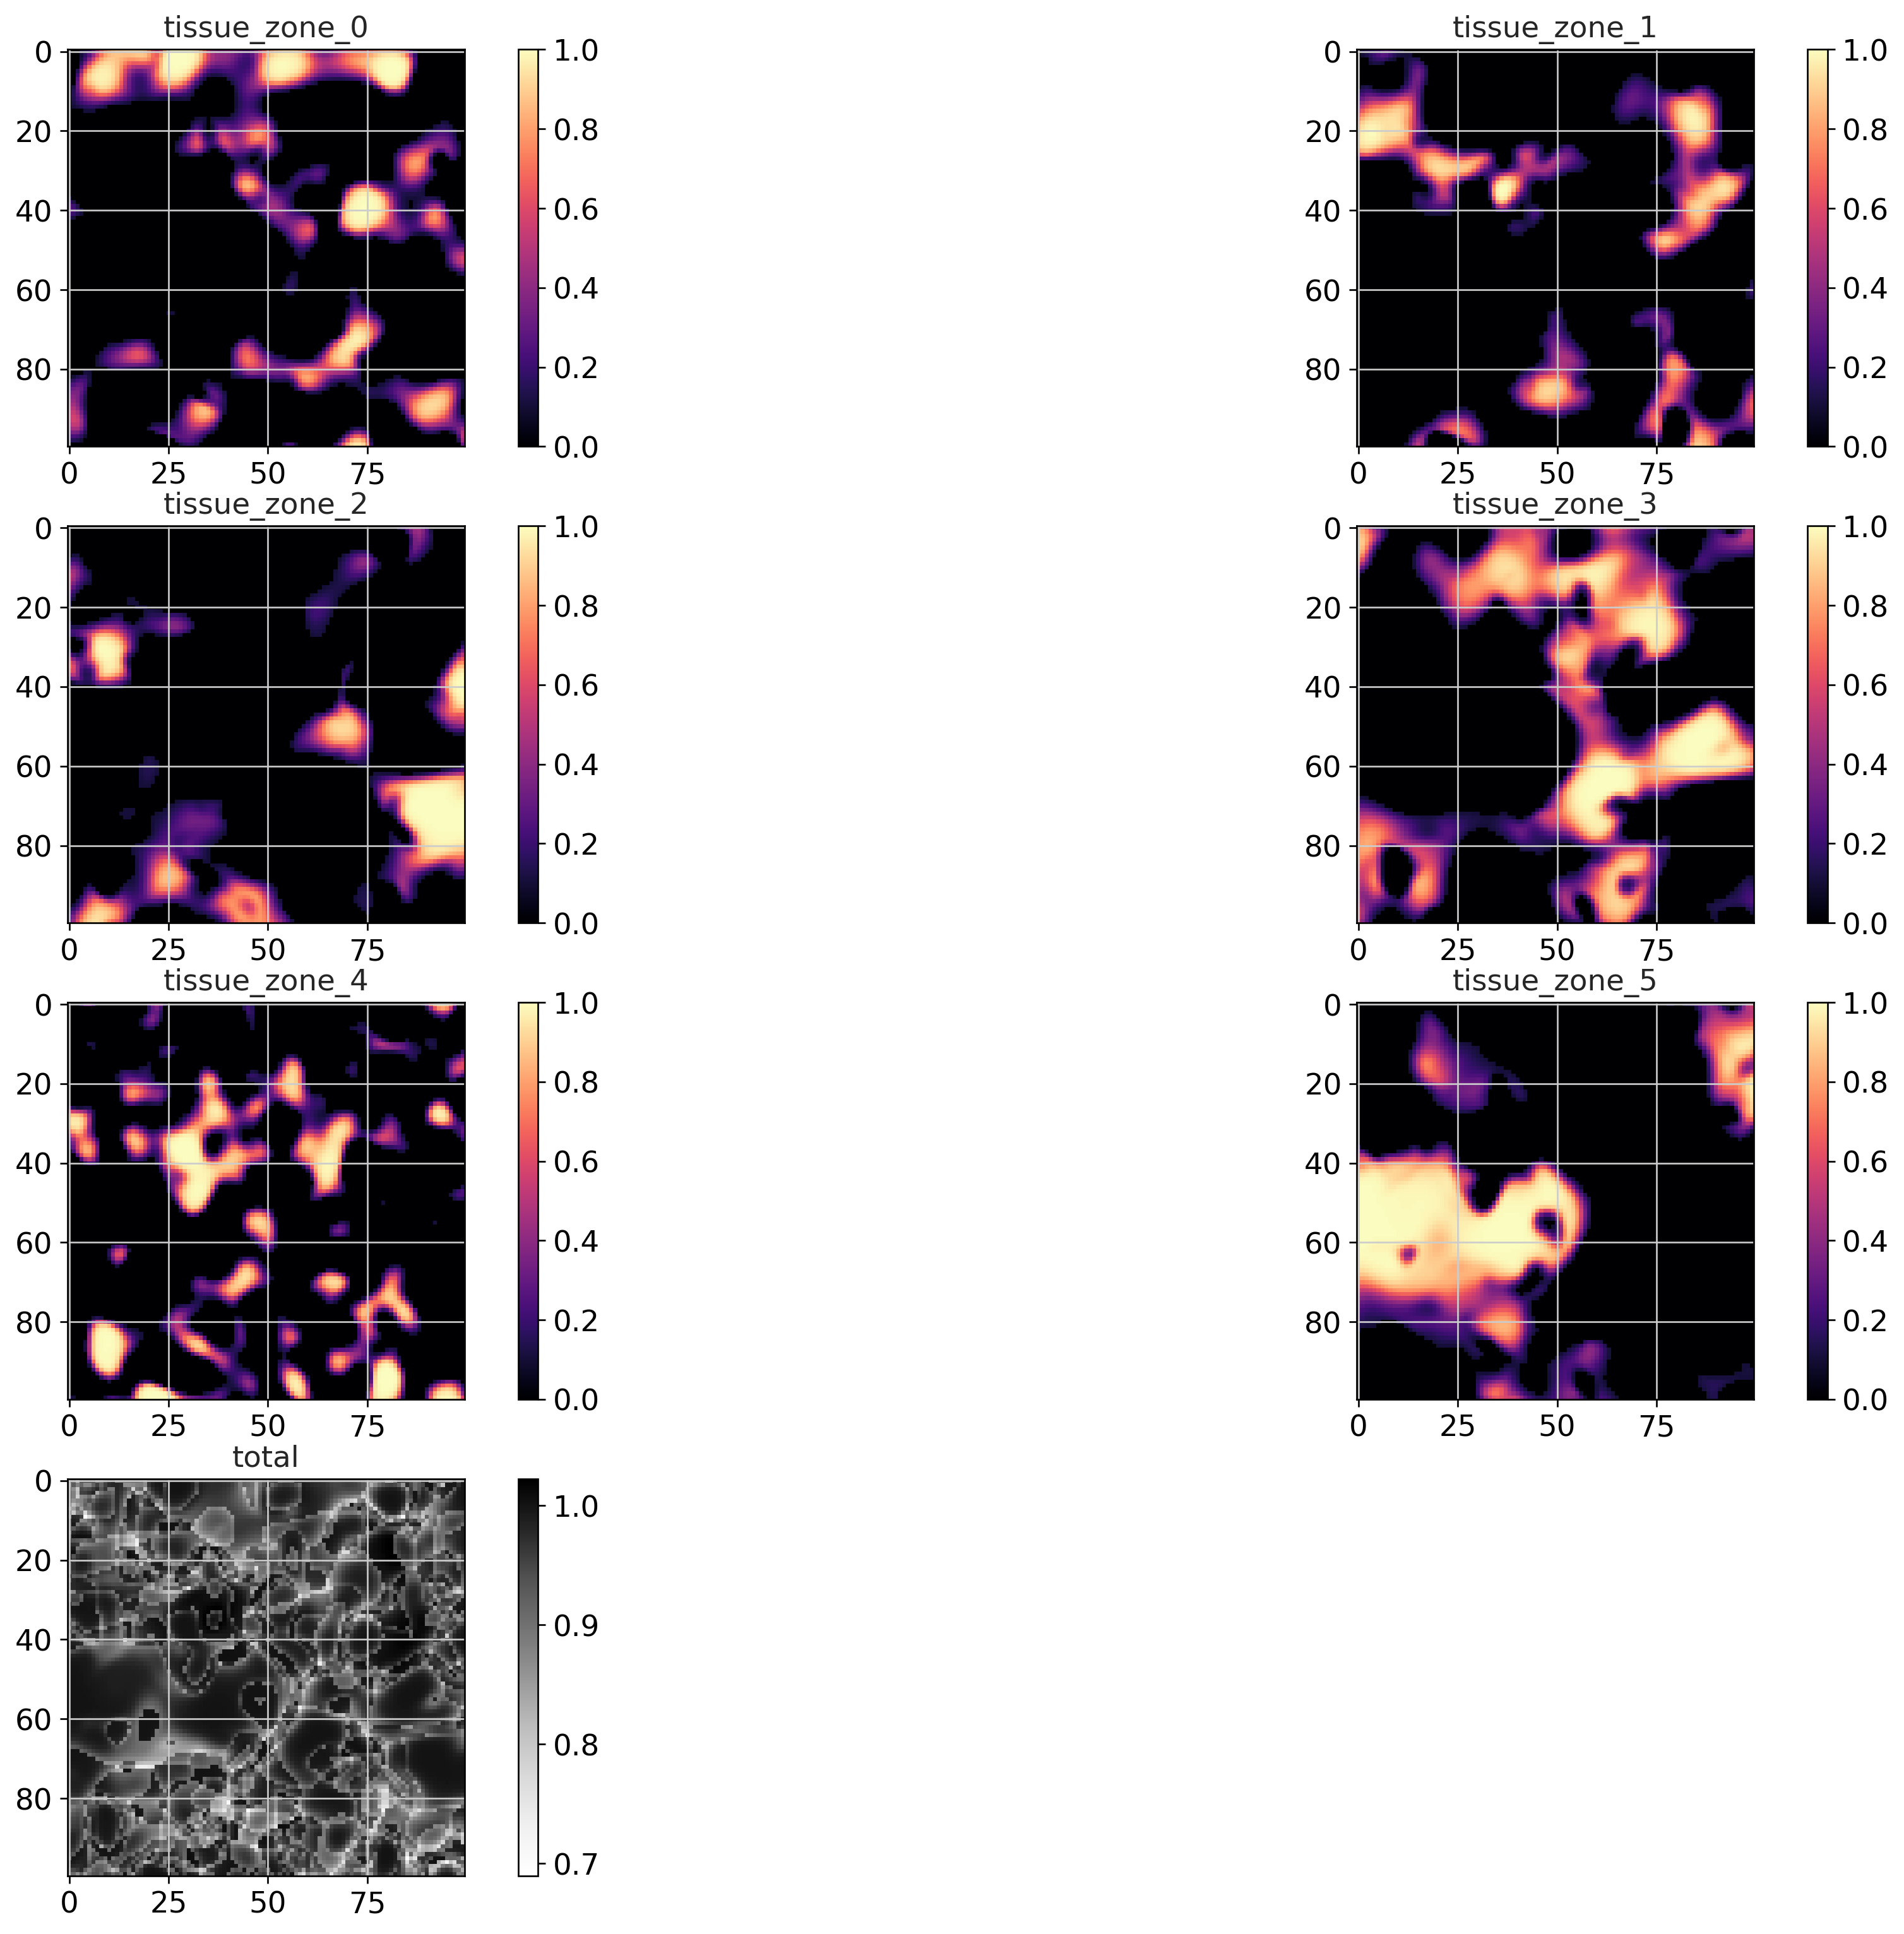

In [13]:
np.random.seed(seed)
# Sample bw parameter
mean_var_ratio = 1.2
mean = 8
tissue_zones_l1_true = np.random.gamma(mean * mean_var_ratio, 1 / mean_var_ratio, 
                                       size=(n_tissue_zones))
uniform_cell_types_l1_true = np.random.gamma(mean * mean_var_ratio, 1 / mean_var_ratio, 
                                             size=(len(uniform_cell_types)))
def sample_GP(locations, x1, x2):
    # Sample abundances with GP
    sparse_abundances = random_GP(X=locations, x1=x1, x2=x2, n_variables=n_tissue_zones, 
                                                    eta_true=1.5,
                                                    l1_true=tissue_zones_l1_true,
                                                    l2_true=tissue_zones_l1_true)
    sparse_abundances = sparse_abundances / sparse_abundances.max(0)
    sparse_abundances[sparse_abundances < 0.1] = 0

    if len(uniform_cell_types!=0):
        uniform_abundances = random_GP(X=locations, x1=x1, x2=x2, n_variables=len(uniform_cell_types), 
                                                          eta_true=0.5,
                                                        l1_true=uniform_cell_types_l1_true,
                                                        l2_true=uniform_cell_types_l1_true)
        uniform_abundances = uniform_abundances / uniform_abundances.max(0) # eq 49
        uniform_abundances[uniform_abundances < 0.1] = 0

        abundances = np.concatenate([sparse_abundances, uniform_abundances], axis=1)
    else:
        abundances = sparse_abundances
    
    return pd.DataFrame(abundances, 
                                 index=[f'location_{i}' for i in range(abundances.shape[0])],
                                 columns=cell_types2zones.columns
                                )

locations_1, x1, x2 = generate_grid(n=n_locations)
locations = np.concatenate([locations_1 for _ in range(n_experiments)], axis=0)

abundances_df = pd.DataFrame()

for e in range(n_experiments):
    
    abundances_df_1 = sample_GP(locations_1, x1, x2)
    abundances_df_1.index = [f'exper{e}_{l}' for l in abundances_df_1.index]
    abundances_df = pd.concat((abundances_df, abundances_df_1), axis=0)
    
    plt.figure(figsize=(3*5+5,3*5+5))
    plot_spatial(abundances_df_1.values, n=n_locations, nrows=5, names=abundances_df.columns)
    plt.show()

In [14]:
# HERE w_sf = sum_r(z_sr,x_rf)*q_sf
np.random.seed(seed)
cell_abundances = np.dot(abundances_df, cell_types2zones.T)
cell_abundances = cell_abundances * np.random.lognormal(0, 0.35, size=cell_abundances.shape)
cell_abundances_df = pd.DataFrame(cell_abundances, 
                             index=abundances_df.index,
                             columns=cell_types2zones.index
                            )
# Plots just the first experiment
# plt.figure(figsize=(3*5+5, 3*10+5))
# plot_spatial(cell_abundances_df.values[experiment_id==0,:], 
#              n=n_locations, nrows=8, 
#              names=cell_abundances_df.columns, vmax=None)
# plt.show()


In [18]:
cell_count_df

,GCBC,NBC-MBC,preB,CD8-T,Th,PDC,PC,myeloid
exper0_location_0,0.0,3.0,0.0,1.0,2.0,0.0,2.0,0.0
exper0_location_1,0.0,5.0,0.0,0.0,1.0,0.0,4.0,0.0
exper0_location_2,0.0,3.0,0.0,0.0,1.0,0.0,3.0,0.0
exper0_location_3,0.0,2.0,0.0,0.0,2.0,0.0,3.0,0.0
exper0_location_4,0.0,3.0,0.0,0.0,1.0,0.0,2.0,0.0
...,...,...,...,...,...,...,...,...
exper0_location_9995,2.0,1.0,0.0,2.0,1.0,0.0,2.0,0.0
exper0_location_9996,4.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0
exper0_location_9997,2.0,1.0,1.0,0.0,1.0,0.0,2.0,0.0
exper0_location_9998,3.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0


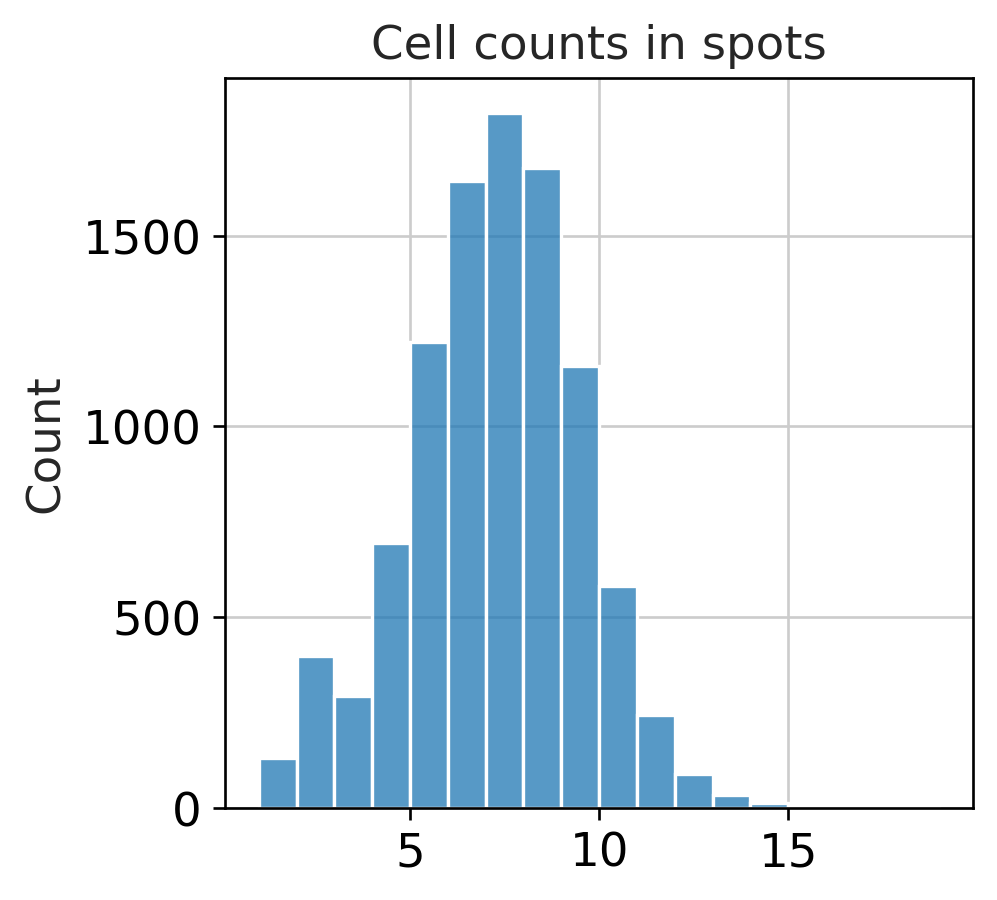

GCBC       13727.0
NBC-MBC    13682.0
preB        3804.0
CD8-T       6972.0
Th          5221.0
PDC         4827.0
PC         12558.0
myeloid     6595.0
dtype: float64

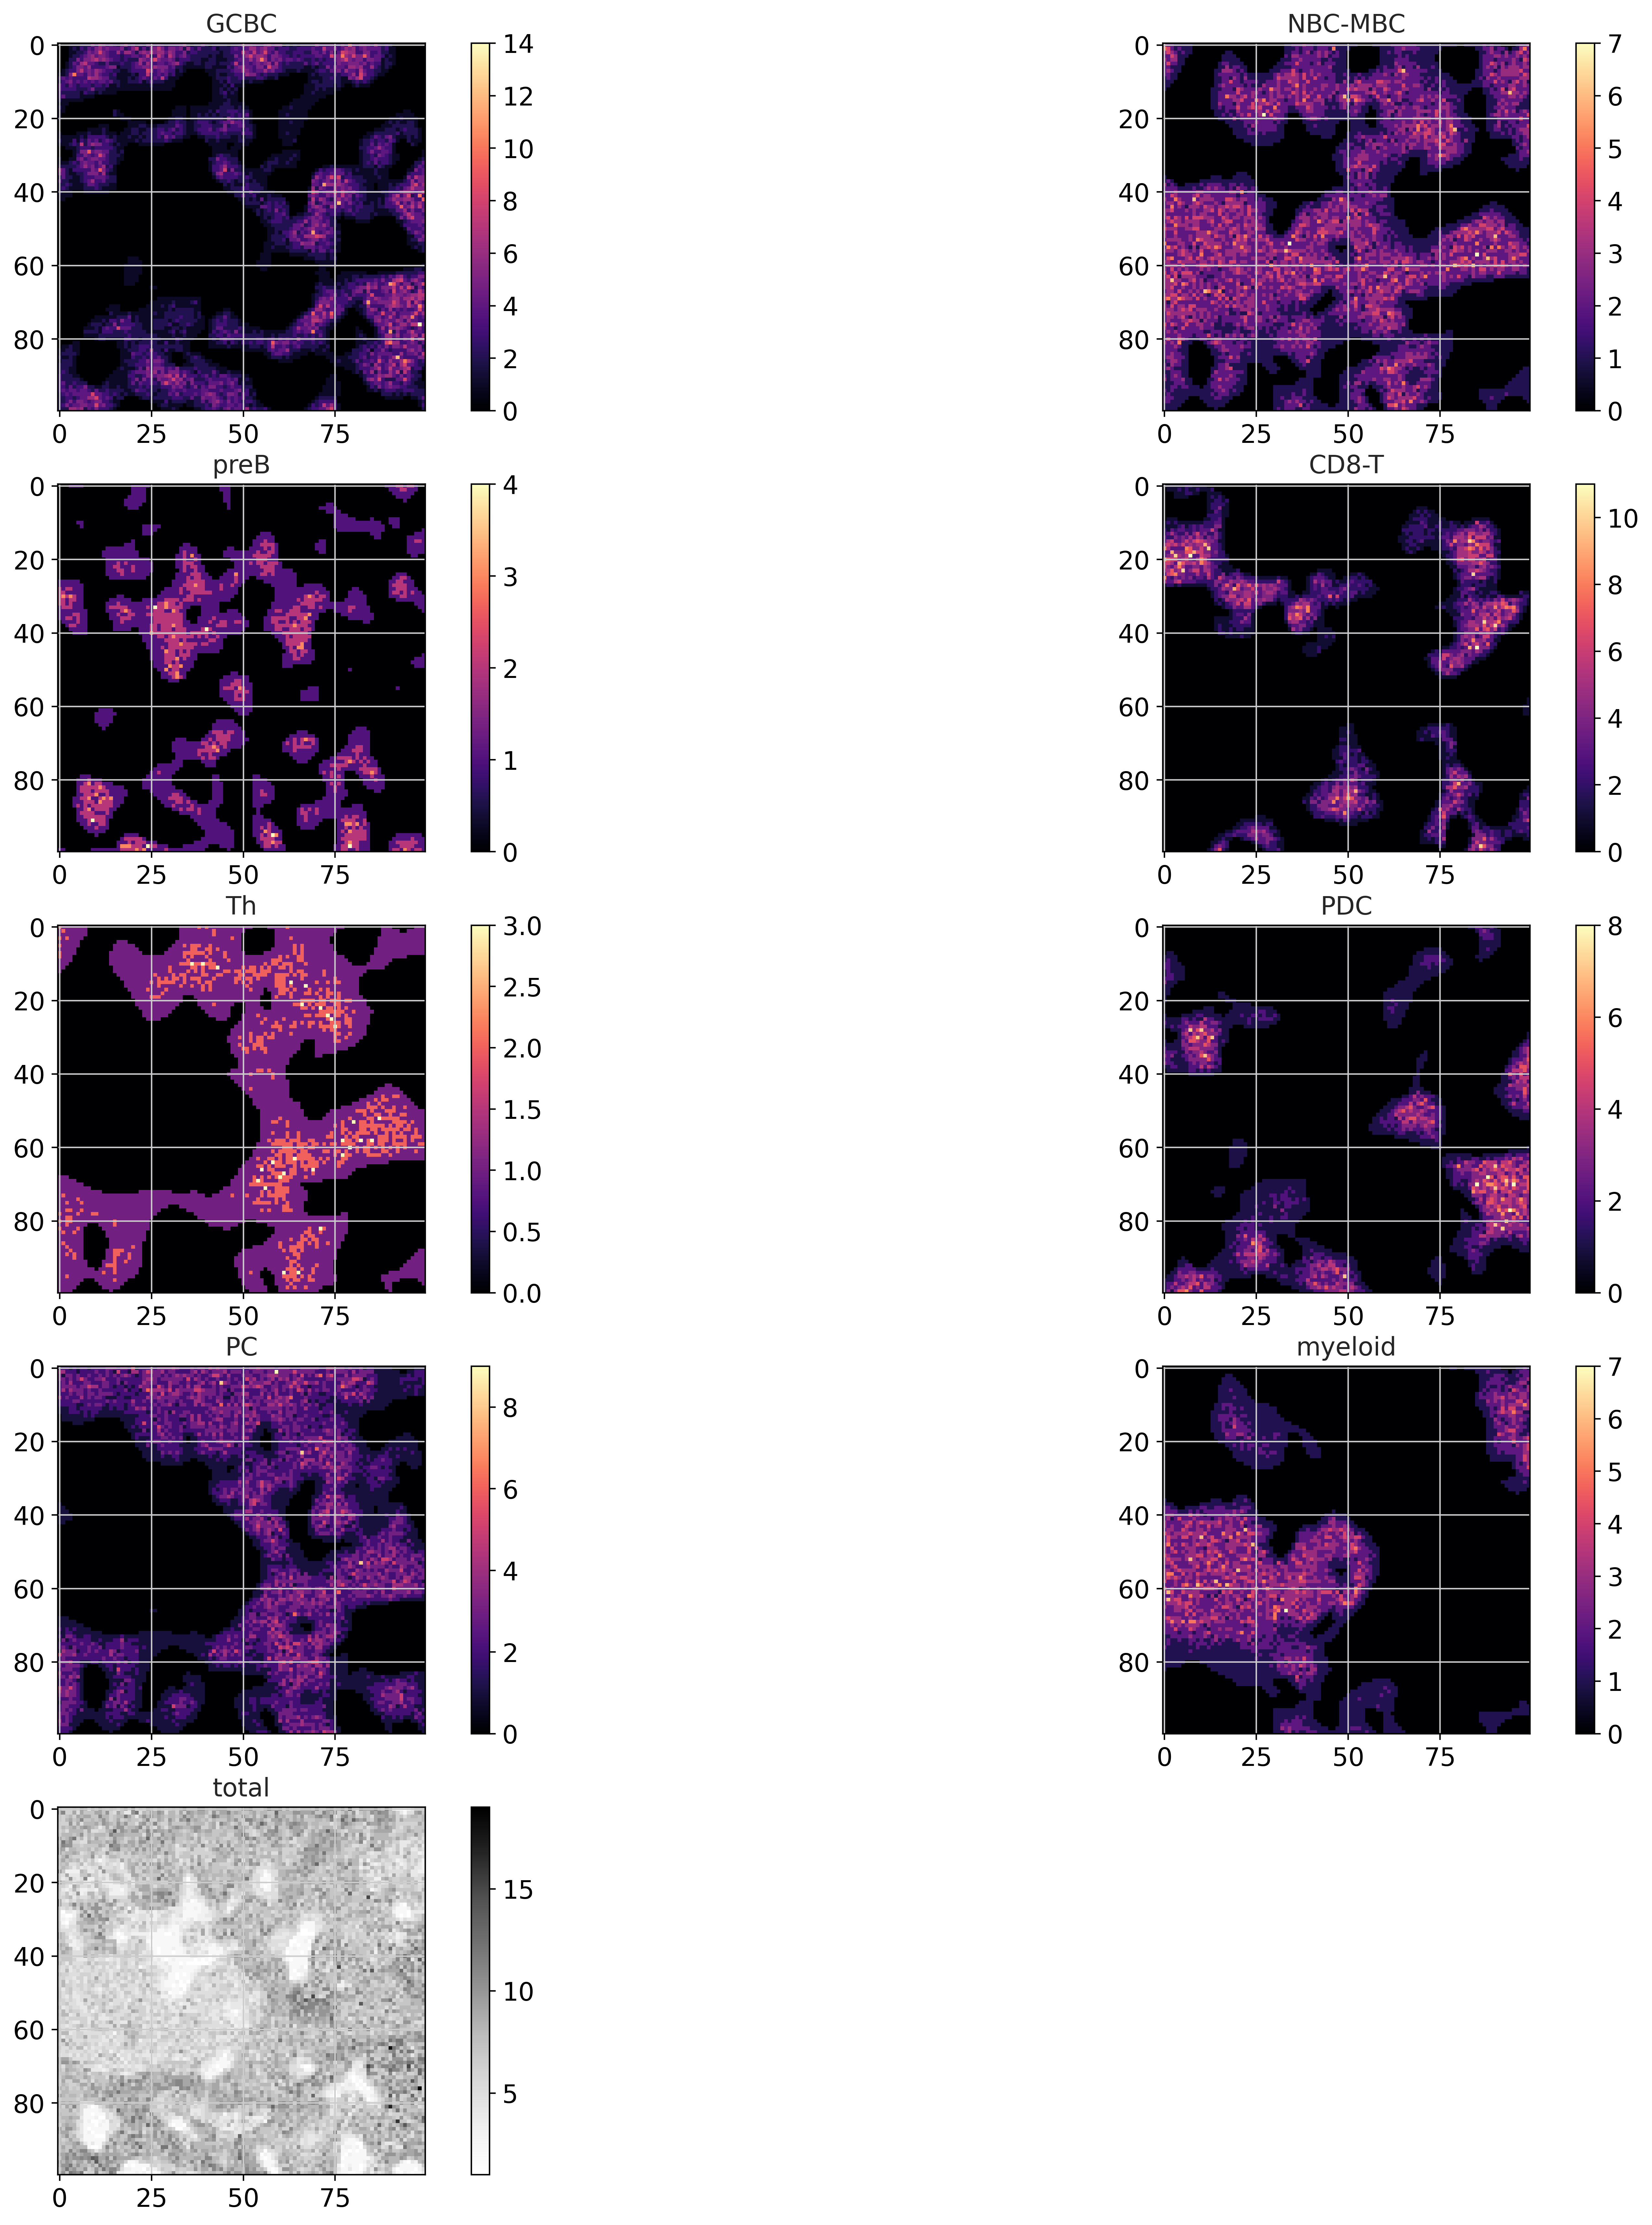

In [15]:
cell_count_df = np.ceil(cell_abundances_df)
sns.histplot(cell_count_df.sum(1),binwidth=1);
plt.title('Cell counts in spots')
plt.show();

plt.figure(figsize=(3*5+5, 3*10+5),dpi=200)
plot_spatial(cell_count_df.values[experiment_id==0,:], 
             n=n_locations, nrows=8, 
             names=cell_count_df.columns, vmax=None)

cell_count_df.sum(0)

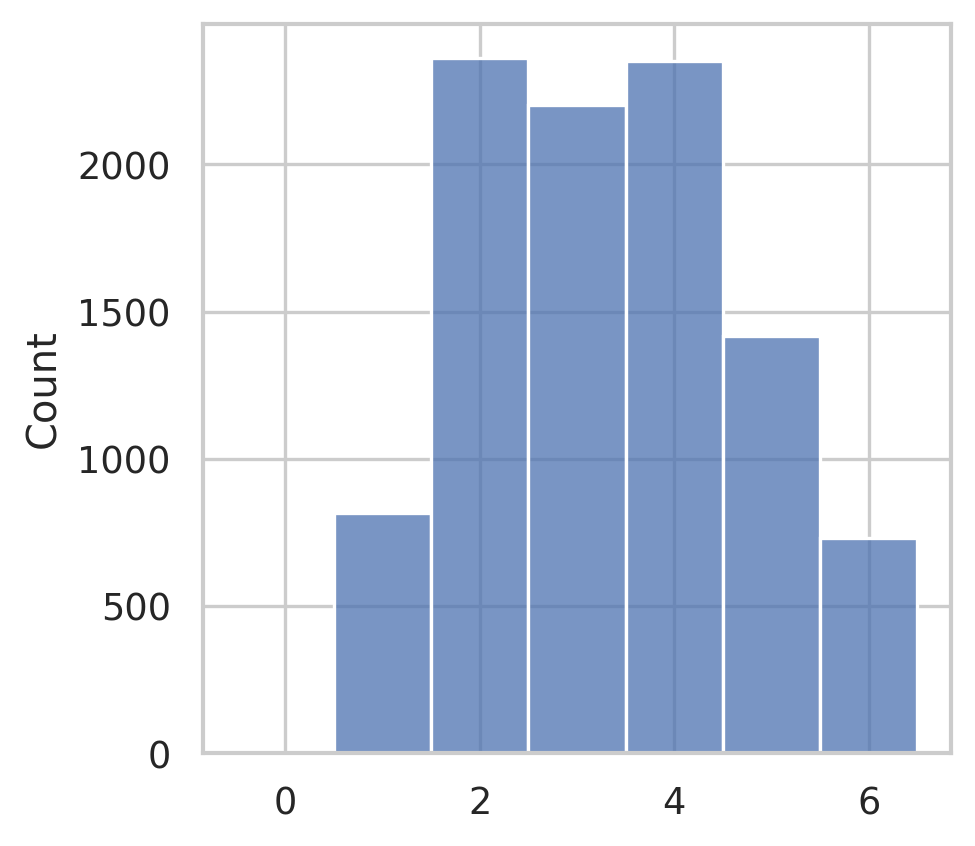

In [19]:
plt.figure(figsize=(4,4),dpi=120)
sns.set_theme(style='whitegrid')
sns.histplot(cell_count_df.astype(bool).astype(int).sum(axis=1),discrete=True,binrange=(0,6))
plt.savefig('../plots/tonsil-multiome-synthetic-spatial-celltype-count-histplot.png',dpi=600)
#plt.title('The number of diferent cell types in spatial spots')

mean n cells: 6.7386


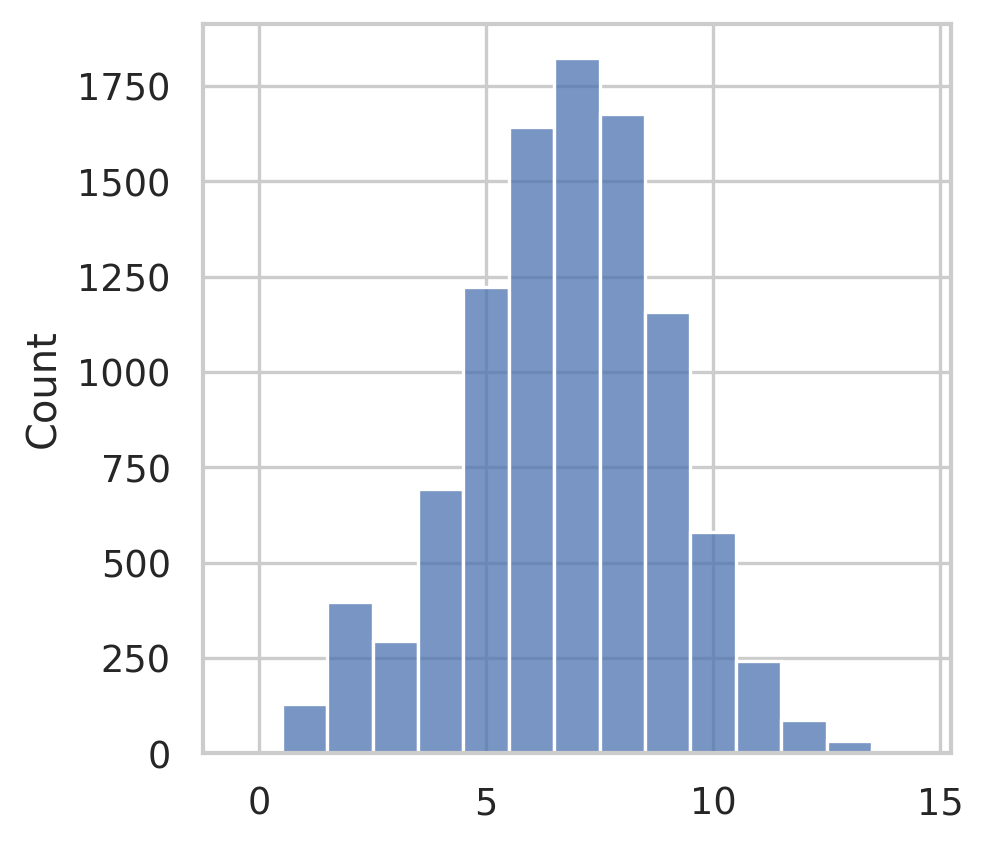

In [24]:
plt.figure(figsize=(4,4),dpi=120)
sns.set_theme(style='whitegrid')
sns.histplot(cell_count_df.sum(axis=1),discrete=True,binrange=(0,14))
plt.savefig('../plots/tonsil-multiome-synthetic-spatial-cell-count-histplot.png',dpi=600)
#plt.title('The number of diferent cell types in spatial spots')
print('mean n cells: '+str(cell_count_df.sum(axis=1).mean()))


In [26]:
def construct_spotwise_expression(expression_df,cells_df,np_seed=seed):
    '''
    expression_df: anndata object with RNA transcript or ATAC peak counts in layer X should
                   contain a column named class_id with identifiers matching those in cells_df

    cells_df: a pandas dataframe containing synthetic spatial spots as rows and cell-types
              as columns. Entries represent integer cell counts of each type in each spot.
              Columns should be named appropriately.
    '''
    
    np.random.seed(np_seed)
    
    spot_bcode_lst = []
    simulated_data = np.empty((len(cells_df),len(expression_df.var)),dtype=np.int16)
    celltypes = cells_df.columns
    
    for row_idx, row in cells_df.reset_index(drop=True).iterrows():
        select_indices = np.empty((0))


        for col_idx,cell_count in enumerate(row): # Iterates over columns in each row
            celltype = celltypes[col_idx]
            celltype_indices = np.where(expression_df.obs['broad_celltype']==celltype)[0] 

            # Random select from matching indices according to number of cells present
            select_indices = np.append(select_indices,np.random.choice(celltype_indices,int(cell_count))).astype(int)

        # Subsets ATAC by selected index and produces a sum of those cells' peaks, appends to 
        # correct synthetic spot
        simulated_data[row_idx,:] = np.sum(expression_df.X[select_indices,:].toarray(),axis=0,dtype=np.int16)

        # Save sampled barcode information into a dict
        spot_bcode_lst.append(rna.obs.index[select_indices].str.cat(sep=','))

    spot_bcode_lst = pd.DataFrame({'sampled_barcodes':spot_bcode_lst},dtype=str)
    spot_bcode_lst.index = cells_df.index
    return simulated_data, spot_bcode_lst


#### Take singular metacell expression and sample it into synthetic spatial spots

In [53]:
# Sanity checks!
expression_df, index_info = construct_spotwise_expression(rna,cell_count_df[:50])
cell_count_df.loc['exper0_location_36']
rna.obs.iloc[index_info['exper0_location_36']]

In [146]:
# Sum the expression of individual cells to form synthetic RNA-spot expression
expression_df, bcode_info = construct_spotwise_expression(rna,cell_count_df)
synthetic_spot_rna_with_broad_celltype = sc.AnnData(X=expression_df,
    obs=cell_count_df,
    var=rna.var)
synthetic_spot_rna_with_broad_celltype.obsm['cell_barcodes'] = bcode_info


/tmp/ipykernel_2085/3281844897.py:3: FutureWarning: X.dtype being converted to np.float32 from int16. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  synthetic_spot_rna_with_broad_celltype = sc.AnnData(X=expression_df,


In [149]:
# Sum the expression of individual cells to form synthetic ATAC-spot expression
expression_df, bcode_info = construct_spotwise_expression(atac,cell_count_df)
synthetic_spot_atac_with_broad_celltype = sc.AnnData(X=expression_df,
    obs=cell_count_df,
    var=atac.var)
synthetic_spot_atac_with_broad_celltype.obsm['cell_barcodes'] = bcode_info



/tmp/ipykernel_2085/3006294277.py:3: FutureWarning: X.dtype being converted to np.float32 from int16. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  synthetic_spot_atac_with_broad_celltype = sc.AnnData(X=expression_df,


In [ ]:
# Save the summed expressions
synthetic_spot_rna_with_broad_celltype.write_h5ad('../integrations/tonsilatlas/sampled_broad_celltypes_all/synthetic_spatial_rna.h5ad')
synthetic_spot_atac_with_broad_celltype.write_h5ad('../integrations/tonsilatlas/sampled_broad_celltypes_all/synthetic_spatial_atac.h5ad')

# Simulating possible cell compositions for "spatial ATAC"

In [1]:

n_locations = [50, 50] 
n_experiments = 20 # Change to 10 when creating actual data
n_zones = 80

# controls for the average number of cells present
mu_density = 5

# Neg binomial prob --- controls the number of cell types present in a given zone
prob = 0.98 # Adjust this 0.9-0.99

## simulation settings
seed = 35342 # changed from 253286


In [8]:
## simulation settings
np.random.seed(seed)

## generate per cell type simulation attributes
cell_types = np.array(rna.obs['broad_celltype'].unique())
n_cell_types = len(cell_types)

# generate matrix of which cell types are in which zones
cell_type_zones = pd.DataFrame(0, index=cell_types, 
                                columns=[f'zone_{i}' for i in range(n_zones)])


# choose 1 to n_cell_type cell types inside each location by choice
dist = np.random.negative_binomial(n_cell_types**2,prob,100000) + 1
dist = dist[(dist <= n_cell_types)]

for i, n in enumerate(cell_type_zones):
    types = np.random.choice(cell_types,np.random.choice(dist),replace=False)
    row_idx = np.where(cell_type_zones.index.isin(types))
    cell_type_zones.iloc[row_idx,i] = 1
    


In [9]:
np.random.seed(seed)
#Generate average abundance for low and high density cell types
mean_var_ratio = 5

gamma_multipliers = np.empty(shape=(n_cell_types,0))

for i in range(len(cell_type_zones.columns)):
    cell_types_present = cell_type_zones[cell_type_zones.columns[i]].sum()
    
    gamma_multipliers = np.hstack([gamma_multipliers,
                              np.random.gamma((mu_density-cell_types_present) * mean_var_ratio, 
                   1/mean_var_ratio, 
                   size=(len(cell_type_zones), 1))])
    
cell_type_zones = cell_type_zones * gamma_multipliers

In [10]:
cell_type_zones

,zone_0,zone_1,zone_2,zone_3,zone_4,zone_5,zone_6,zone_7,zone_8,zone_9,...,zone_70,zone_71,zone_72,zone_73,zone_74,zone_75,zone_76,zone_77,zone_78,zone_79
GCBC,0.000000,2.466898,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,2.385735,...,0.00000,0.000000,0.000000,0.00000,0.000000,0.000000,1.534488,2.184667,0.000000,0.000000
NBC-MBC,2.393659,0.000000,4.929261,0.000000,0.000000,0.0,0.000000,0.000000,0.0,2.686492,...,0.00000,3.130213,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,3.539417
preB,0.000000,0.000000,3.100062,3.533824,0.000000,0.0,3.863174,0.000000,0.0,0.000000,...,0.00000,0.000000,0.000000,0.00000,2.627077,0.000000,1.952715,0.000000,0.000000,1.734628
CD8-T,0.000000,1.258934,0.000000,0.000000,0.835225,0.0,1.890073,4.180004,0.0,2.282812,...,0.00000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,3.994029,0.000000
Th,0.000000,0.000000,0.000000,0.000000,0.982782,0.0,2.009918,0.000000,0.0,0.000000,...,0.00000,2.537020,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,1.180572
PDC,0.000000,0.000000,0.000000,0.000000,0.566680,0.0,0.000000,0.000000,0.0,0.000000,...,0.00000,0.000000,4.050934,0.00000,3.312108,0.000000,0.000000,4.827788,0.000000,0.000000
PC,0.000000,2.141443,0.000000,0.000000,0.690879,0.0,0.000000,3.134717,0.0,0.000000,...,0.00000,0.000000,0.000000,4.27755,0.000000,3.851543,2.084319,0.000000,0.000000,0.000000
myeloid,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,...,5.48652,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [16]:
# Gaussian process over the spatial grids, takes about an hour, for 20 50x50 grids.
np.random.seed(seed)
# Sample bw parameter
mean_var_ratio = 1.2
mean = 8
tissue_zones_l1_true = np.random.gamma(mean * mean_var_ratio, 1 / mean_var_ratio, 
                                       size=(n_zones))

def sample_GP(locations, x1, x2):
    # Sample abundances with GP
    abundances = random_GP(X=locations, x1=x1, x2=x2, n_variables=n_zones, 
                                                    eta_true=1.5,
                                                    l1_true=tissue_zones_l1_true,
                                                    l2_true=tissue_zones_l1_true)
    abundances = abundances / abundances.max(0)
    abundances[abundances < 0.1] = 0
    
    return pd.DataFrame(abundances, 
                                 index=[f'location_{i}' for i in range(abundances.shape[0])],
                                 columns=cell_type_zones.columns
                                )

locations_1, x1, x2 = generate_grid(n=n_locations)
locations = np.concatenate([locations_1 for _ in range(n_experiments)], axis=0)

abundances_df = pd.DataFrame()

for e in range(n_experiments):
    print('Working on experiment '+ str(e))
    abundances = random_GP(X=locations_1, x1=x1, x2=x2, n_variables=n_zones, 
                                                    eta_true=1.5,
                                                    l1_true=tissue_zones_l1_true,
                                                    l2_true=tissue_zones_l1_true)
    abundances = abundances / abundances.max(0)
    abundances[abundances < 0.1] = 0
    
    abundances_df_1 = pd.DataFrame(abundances, 
                                 index=[f'location_{i}' for i in range(abundances.shape[0])],
                                 columns=cell_type_zones.columns
                                )
    
    abundances_df_1.index = [f'exper{e}_{l}' for l in abundances_df_1.index]
    abundances_df = pd.concat((abundances_df, abundances_df_1), axis=0)
    

Working on experiment 0
Working on experiment 1
Working on experiment 2
Working on experiment 3
Working on experiment 4
Working on experiment 5
Working on experiment 6
Working on experiment 7
Working on experiment 8
Working on experiment 9
Working on experiment 10
Working on experiment 11
Working on experiment 12
Working on experiment 13
Working on experiment 14
Working on experiment 15
Working on experiment 16
Working on experiment 17
Working on experiment 18
Working on experiment 19


In [17]:
# HERE w_sf = sum_r(z_sr,x_rf)*q_sf
np.random.seed(seed)
cell_abundances = np.dot(abundances_df, cell_type_zones.T)
cell_abundances = cell_abundances * np.random.lognormal(0, 0.35, size=cell_abundances.shape)
cell_abundances_df = pd.DataFrame(cell_abundances, 
                             index=abundances_df.index,
                             columns=cell_type_zones.index
                            )

cell_count_df = np.ceil(cell_abundances_df)        

In [19]:
cell_count_df

,GCBC,NBC-MBC,preB,CD8-T,Th,PDC,PC,myeloid
exper0_location_0,2.0,1.0,3.0,2.0,1.0,1.0,1.0,0.0
exper0_location_1,2.0,1.0,4.0,1.0,1.0,1.0,0.0,0.0
exper0_location_2,2.0,4.0,3.0,1.0,3.0,3.0,0.0,0.0
exper0_location_3,0.0,2.0,2.0,1.0,2.0,4.0,0.0,0.0
exper0_location_4,0.0,1.0,3.0,1.0,2.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...
exper19_location_2495,2.0,0.0,1.0,2.0,0.0,0.0,1.0,0.0
exper19_location_2496,1.0,0.0,1.0,5.0,0.0,0.0,1.0,0.0
exper19_location_2497,1.0,0.0,1.0,3.0,0.0,0.0,1.0,0.0
exper19_location_2498,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0


In [20]:
cell_count_df.to_csv('../integrations/tonsilatlas/sampled_broad_celltypes_all/simulated-atac-cell-count-matrix.csv')

mean n cells: 8.60654


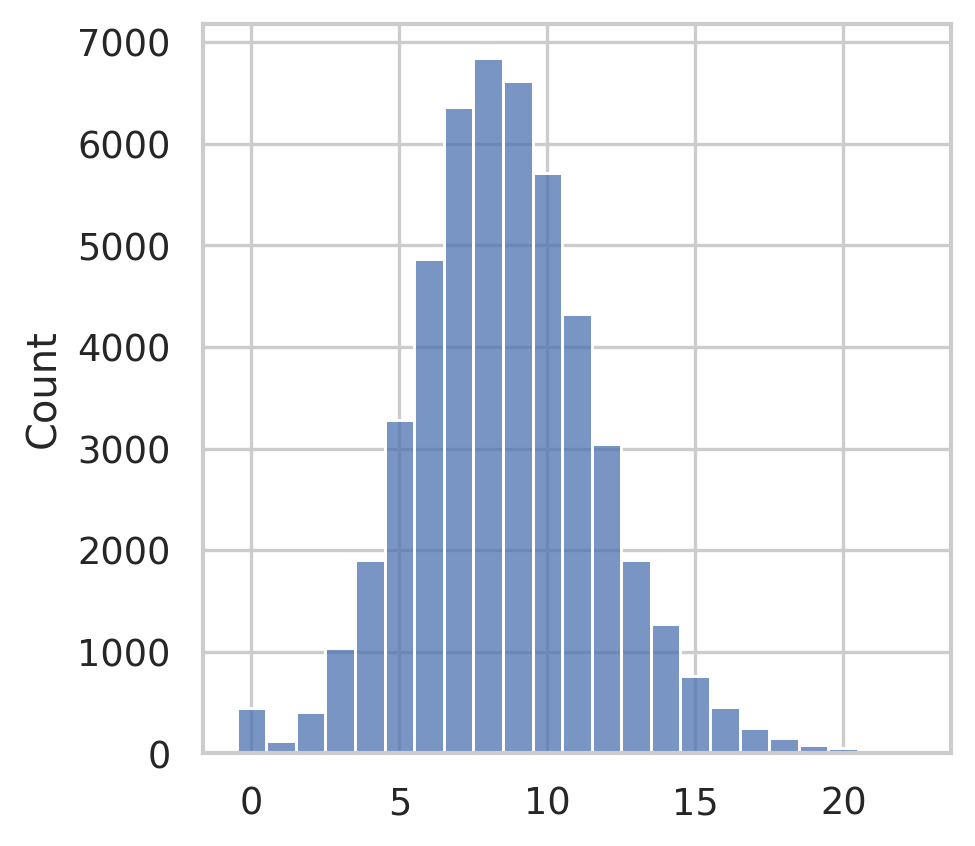

In [34]:
plt.figure(figsize=(4,4),dpi=120)
sns.set_theme(style='whitegrid')
sns.histplot(cell_count_df.sum(axis=1),discrete=True,binrange=(0,22))
plt.savefig('../plots/tonsil-multiome-simulated-spatial-cell-count-histplot.png',dpi=600)
#plt.title('The number of diferent cell types in spatial spots')
print('mean n cells: '+str(cell_count_df.sum(axis=1).mean()))


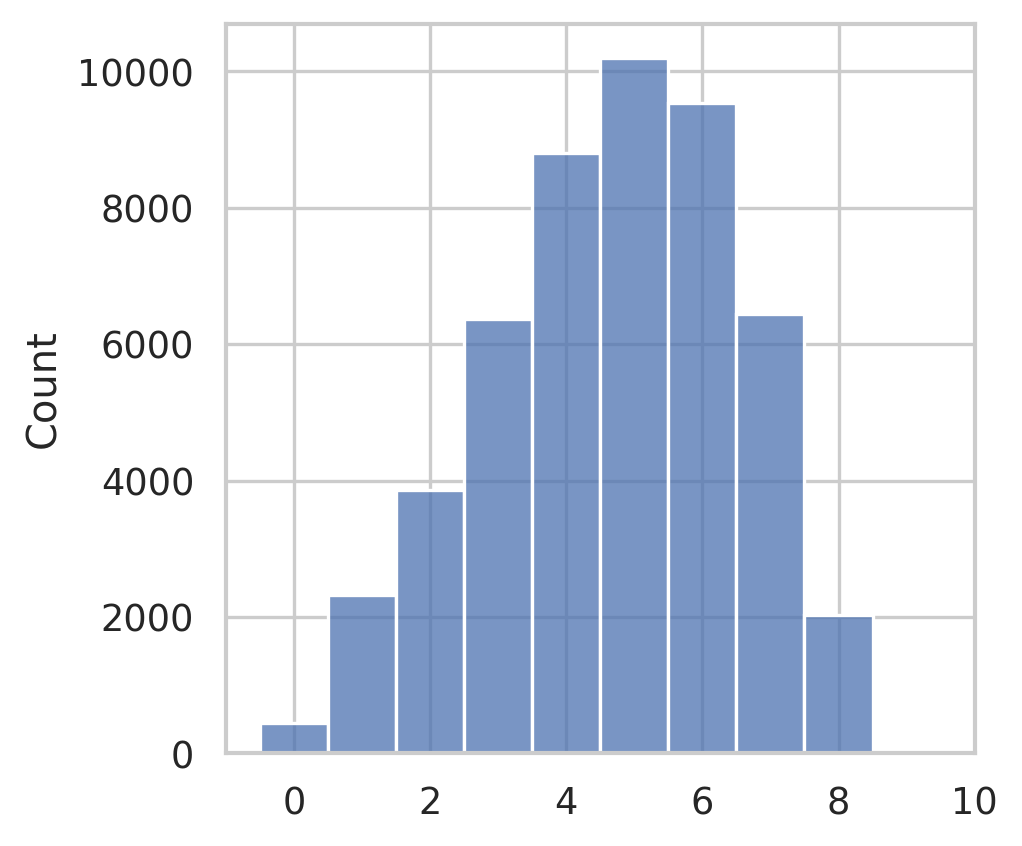

In [36]:
plt.figure(figsize=(4,4),dpi=120)
sns.set_theme(style='whitegrid')
sns.histplot(cell_count_df.astype(bool).astype(int).sum(axis=1),discrete=True,binrange=(0,9))
plt.savefig('../plots/tonsil-multiome-simulated-spots-celltype-count-histplot.png',dpi=600)
#plt.title('The number of diferent cell types in spatial spots')

### Write simulated spots into RNA & ATAC matrices

In [ ]:
#cell_count_df = pd.read_csv('../integrations/tonsilatlas/sampled_broad_celltypes_all/'index_col=False)

#### Sampling individual cells into the simulated spots

In [28]:
# Sum the expression of individual cells to form synthetic ATAC-spot expression
expression_df, bcode_info = construct_spotwise_expression(atac,cell_count_df,np_seed=245212) # This cell_count_df is now for the simulated spots
simulated_spot_atac_with_broad_celltype = sc.AnnData(X=expression_df,
    obs=cell_count_df,
    var=atac.var)
simulated_spot_atac_with_broad_celltype.obsm['cell_barcodes'] = bcode_info

simulated_spot_atac_with_broad_celltype.write_h5ad('../integrations/tonsilatlas/sampled_broad_celltypes_all/simulated_spots_atac.h5ad')
del simulated_spot_atac_with_broad_celltype # delete to free up some RAM (26GB on disk, phew)


/tmp/ipykernel_19833/71019621.py:3: FutureWarning: X.dtype being converted to np.float32 from int16. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  simulated_spot_atac_with_broad_celltype = sc.AnnData(X=expression_df,


In [32]:
# Sum the expression of individual cells to form simulated RNA-spot expression
expression_df, bcode_info = construct_spotwise_expression(rna,cell_count_df,np_seed=245212) # This cell_count_df is now for the simulated spots
simulated_spot_rna_with_broad_celltype = sc.AnnData(X=expression_df,
    obs=cell_count_df,
    var=rna.var)
simulated_spot_rna_with_broad_celltype.obsm['cell_barcodes'] = bcode_info

# Save the summed expressions
simulated_spot_rna_with_broad_celltype.write_h5ad('../integrations/tonsilatlas/sampled_broad_celltypes_all/simulated_spots_rna.h5ad')
del simulated_spot_rna_with_broad_celltype

/tmp/ipykernel_19833/4044945682.py:3: FutureWarning: X.dtype being converted to np.float32 from int16. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  simulated_spot_rna_with_broad_celltype = sc.AnnData(X=expression_df,
